## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB

## Data preprocessing

(10000, 16)
                       Timestamp        Source IP  Destination IP  \
0  2024-01-01 00:00:00.000000000  109.222.113.178   126.56.207.17   
1  2024-01-01 00:21:53.411341134     29.137.28.77   84.229.152.46   
2  2024-01-01 00:43:46.822682268    222.178.3.248     23.20.1.137   
3  2024-01-01 01:05:40.234023402    18.167.89.178  129.111.92.250   
4  2024-01-01 01:27:33.645364536     149.68.9.173   180.121.15.72   

         Query Name Query Type Response Code    TTL  Transaction ID  \
0  smith-bowers.com          A      SERVFAIL  15404           41565   
1          gray.com          A      NXDOMAIN  69230           62642   
2        keller.com      CNAME      SERVFAIL  75349           60360   
3         lewis.com          A      SERVFAIL  50656           27809   
4      gonzalez.com          A      SERVFAIL  48772           48936   

   Query Volume  Anomaly Flag           DNS Proxy Name  \
0           595             0          Leonard-Flowers   
1           489             0 

C:\Users\ZIAD\AppData\Local\Temp\ipykernel_34928\4157402373.py:17: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  transaction_entropy = data.groupby('Timestamp')['Transaction ID'].apply(lambda x: entropy(pd.value_counts(x, normalize=True)))


(10000, 7)


<Axes: ylabel='count'>

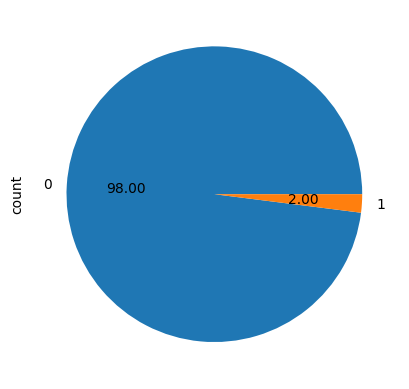

In [2]:
# Load Dataset
data_path = "synthetic_dns_logs.csv"
data = pd.read_csv(data_path)
print(data.shape)
print("="*50)
print(data.head(5))

# Drop Unnecessary Columns
unnecessary_columns = ["DNS Proxy Name", "Comment", "Unused Data 1", "Unused Data 2", "Log Source", "Empty Field"]
data = data.drop(columns=unnecessary_columns, errors='ignore')

# Feature Engineering
# Feature 1: Query Volume per Timestamp
data['Query Volume'] = data.groupby('Timestamp')['Transaction ID'].transform('count')

# Feature 2: Entropy of Transaction IDs
transaction_entropy = data.groupby('Timestamp')['Transaction ID'].apply(lambda x: entropy(pd.value_counts(x, normalize=True)))
data['Transaction ID Entropy'] = data['Timestamp'].map(transaction_entropy)

# Feature 3: Average TTL per Timestamp
data['Average TTL'] = data.groupby('Timestamp')['TTL'].transform('mean')

# Drop Duplicate Timestamps
data = data.drop_duplicates(subset=['Timestamp'])

# Encode Categorical Features
label_encoder = LabelEncoder()
data['Query Type'] = label_encoder.fit_transform(data['Query Type'])
data['Response Code'] = label_encoder.fit_transform(data['Response Code'])

# Define Features and Target
X = data.drop(columns=['Anomaly Flag', 'Timestamp', 'Source IP', 'Destination IP', 'Query Name'])
y = data['Anomaly Flag']

print(X.shape)
print("="*50)

# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=10, stratify=y)
y_train.value_counts().plot.pie(autopct='%.2f')





## handeling imbalance data

(13720, 7)
(13720,)


<Axes: ylabel='count'>

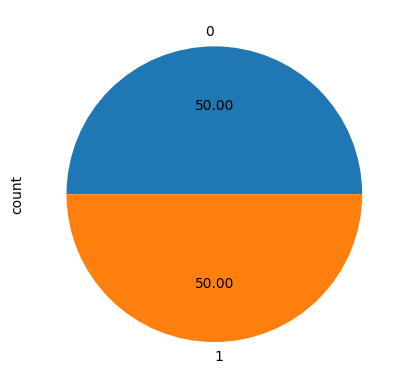

In [3]:
# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)
y_train_smote.value_counts().plot.pie(autopct='%.2f')

## model evaluation

In [4]:
# Models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000)
}

# Model Training & Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    
    # Save the confusion matrix plot
    file_name = f"{model_name.replace(' ', '_')}-matrix.png"
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix saved as {file_name}")
    
    # Show the plot
    plt.show()


## Models

--- Random Forest ---
Accuracy: 0.9163
Precision: 0.0296
Recall: 0.1000
F1-Score: 0.0456
Confusion matrix saved as Random_Forest-matrix.png


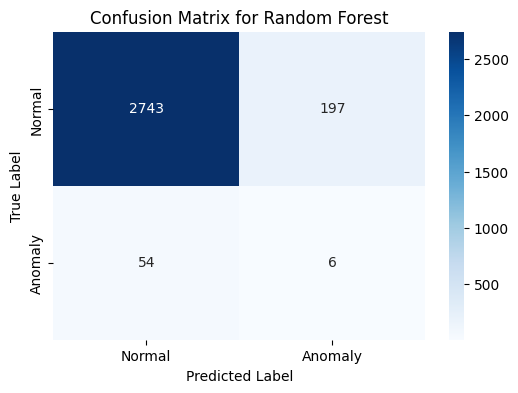

--- Naive Bayes ---
Accuracy: 0.5593
Precision: 0.0284
Recall: 0.6333
F1-Score: 0.0544
Confusion matrix saved as Naive_Bayes-matrix.png


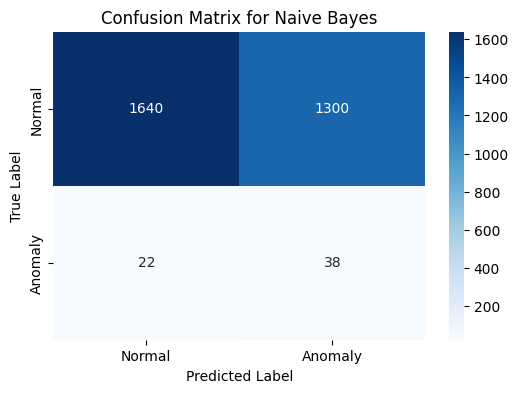

--- Logistic Regression ---
Accuracy: 0.5573
Precision: 0.0247
Recall: 0.5500
F1-Score: 0.0473
Confusion matrix saved as Logistic_Regression-matrix.png


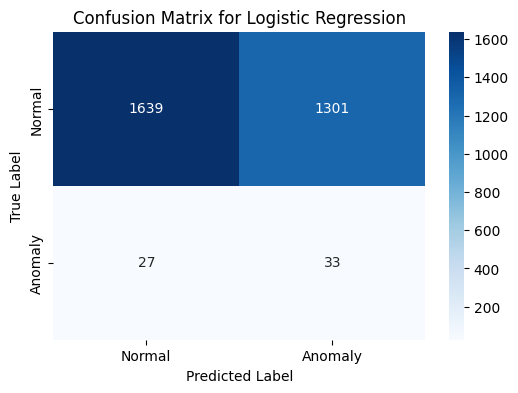

In [5]:
# Evaluate Each Model
results = {}
for model_name, model in models.items():
    print(f"--- {model_name} ---")
    evaluate_model(model, X_train_smote, X_test, y_train_smote, y_test, model_name)
    results[model_name] = model

## F1 comparison

In [6]:
# Model Comparison using Accuracy
print("Model Comparison (Accuracy):")
comparison_df = pd.DataFrame({
    "Model": list(models.keys()),  # Fetch the model names from the dictionary
    "F1-Score": [
        f1_score(y_test, results[model_name].predict(X_test)) for model_name in models
    ]
})
print(comparison_df)


Model Comparison (Accuracy):
                 Model  F1-Score
0        Random Forest  0.045627
1          Naive Bayes  0.054363
2  Logistic Regression  0.047346


## Comparison Visualization

C:\Users\ZIAD\AppData\Local\Temp\ipykernel_34928\3093533646.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-Score', data=comparison_df, palette='viridis')


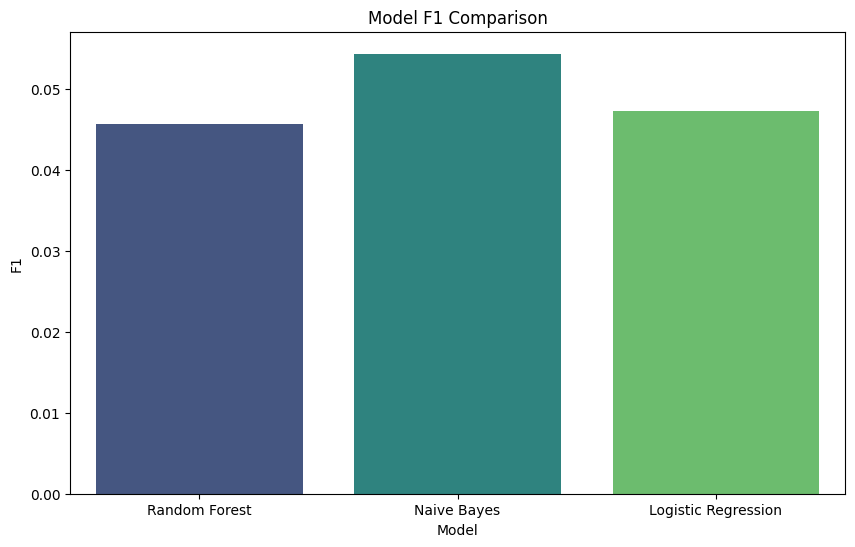


Best Model: Naive Bayes with F1-Score: 0.05


<Figure size 640x480 with 0 Axes>

In [7]:
# Visualize Model Performance
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1-Score', data=comparison_df, palette='viridis')
plt.title("Model F1 Comparison")
plt.ylabel("F1")
plt.xlabel("Model")
plt.show()
plt.savefig("Model F1 Comparison")

# Print Best Model
best_model = comparison_df.loc[comparison_df['F1-Score'].idxmax()]
print(f"\nBest Model: {best_model['Model']} with F1-Score: {best_model['F1-Score']:.2f}")

## Accuracy Comparison

In [8]:
print("Model Comparison (Accuracy):")
comparison_df = pd.DataFrame({
    "Model": list(models.keys()),  # Fetch the model names from the dictionary
    "Accuracy": [
        accuracy_score(y_test, results[model_name].predict(X_test))* 100 for model_name in models
    ]
})
print(comparison_df)

Model Comparison (Accuracy):
                 Model   Accuracy
0        Random Forest  91.633333
1          Naive Bayes  55.933333
2  Logistic Regression  55.733333


## Comparison visualization

C:\Users\ZIAD\AppData\Local\Temp\ipykernel_34928\3689293057.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')


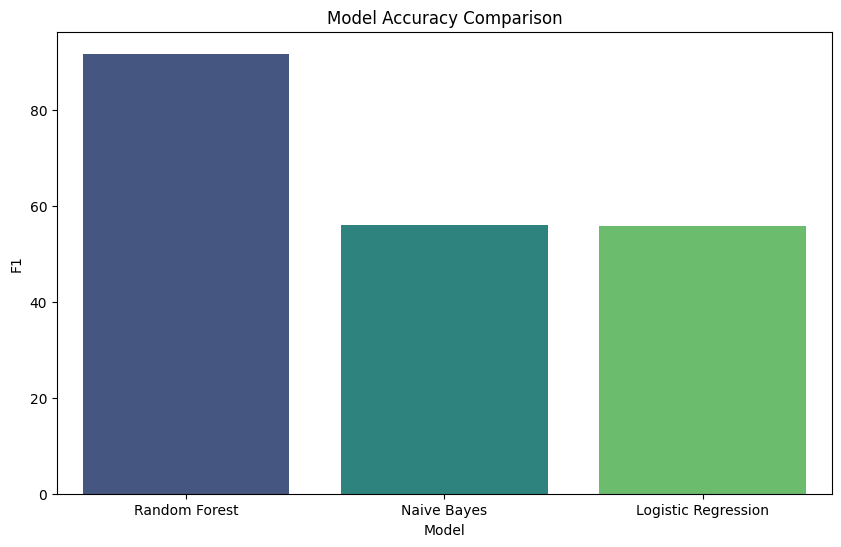


Best Model: Random Forest with Accuracy: 91.63%


<Figure size 640x480 with 0 Axes>

In [9]:
# Visualize Model Performance
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylabel("F1")
plt.xlabel("Model")
plt.show()
plt.savefig("Model Accuracy Comparison")

# Print Best Model
best_model = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
print(f"\nBest Model: {best_model['Model']} with Accuracy: {best_model['Accuracy']:.2f}%")